# SAG和SVRG优化算法实现


------------------

## 1 理论分析

#### 1.1 梯度聚合
背景：如课上韩老师提到的，SGD随机抽样带来的大方差，使得估计不准确，且收敛速度慢，因此提出了方差缩减的一系列改进。  
梯度聚合类算法之所以能实现方差缩减，思想就在于重用先前计算过的梯度信息来实现方差缩小，在相近的迭代步的情况下随机梯度的相关性很强，因此这样做显然是有道理的。那么关于“相近的迭代步”的实现有两种方法，这便引出了本次作业的两个算法：  
1、存储每个分量函数最近一次计算的梯度——SAG算法  
2、在迭代过程中每隔几步计算一次全梯度——SVRG算法  

#### 1.2 SAG算法
*来自论文： A Stochastic Gradient Method with an Exponential Convergence Rate for Finite Training Sets.*  
在内存中为每个样本都维护最近一次计算的梯度，每次更新的时候仅仅需要计算一个样本的梯度，是一种线性收敛算法，但是内存开销大。伪代码如下：  

---
$d=0, y_{i}=0$ for $i=1,2, \ldots, n$  
for $k=0,1, \ldots$ do  
&nbsp;&nbsp;Sample $i$ from $\{1,2, \ldots, n\}$  
&nbsp;&nbsp;$d=d-y_{i}+f_{i}^{\prime}(x)$  
&nbsp;&nbsp;$y_{i}=f_{i}^{\prime}(x)$  
&nbsp;&nbsp;$x=x-\frac{\alpha}{n} d$  
end for  

---


#### 1.3 SVRG算法
*来自论文：Accelerating Stochastic Gradient Descent using Predictive Variance Reduction.*  
在迭代过程中每隔几步计算一次全梯度，相对于SAG来说，不需要在内存中为每个样本都维护梯度，也是线性收敛算法。伪代码如下：

---
Parameters update frequency $m$ and learning rate $\eta$  
Initialize $\tilde{w}_{0}$  
Iterate: for $s=1,2, \ldots$  
&nbsp;&nbsp;$\tilde{w}=\tilde{w}_{s-1}$  
&nbsp;&nbsp;$\tilde{\mu}=\frac{1}{n} \sum_{i=1}^{n} \nabla \psi_{i}(\tilde{w})$  
&nbsp;&nbsp;$w_{0}=\tilde{w}$  
&nbsp;&nbsp;Iterate: for $t=1,2, \ldots, m$  
&nbsp;&nbsp;&nbsp;&nbsp;Randomly pick $i_{t} \in\{1, \ldots, n\}$ and update weight  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$w_{t}=w_{t-1}-\eta\left(\nabla \psi_{i_{t}}\left(w_{t-1}\right)-\nabla \psi_{i_{t}}(\tilde{w})+\tilde{\mu}\right)$  
&nbsp;&nbsp;end  
&nbsp;&nbsp;option I: set $\tilde{w}_{s}=w_{m}$ **本次作业我们选择option I实现！**   
&nbsp;&nbsp;option II: set $\tilde{w}_{s}=w_{t}$ for randomly chosen $t \in\{0, \ldots, m-1\}$  
end  

---

## 2 问题建模：
### 将二分类问题建模成L2正则逻辑回归[L2-regularized Logistic Regression]

#### 2.1 目标loss函数
$$\underset{w \in \mathbb{R}^{p}}{\operatorname{minimize}} \quad g(w):=\frac{1}{n} \sum_{i=1}^{n} f_{i}(w)$$  
$$f_{i}(w):=\frac{\lambda}{2}\|w\|^{2}+\log (1+\left.\exp \left(-y_{i} x_{i}^{T} w\right)\right)$$  
其中$x_{i} \in \mathbb{R}^{p} \text { and } y_{i} \in\{-1,1\}$是总共n个样本的特征以及标签，优化的变量是权重$w$。  
#### 2.2 每个样本损失函数的导函数：

$$\nabla f_{i}(w) = \lambda w - \frac{y_i \exp \left(-y_{i} x_{i}^{T} w\right)}{1+ \exp \left(-y_{i} x_{i}^{T} w\right)}x_i$$

----------

## 3 实验部分
### 3.1.1 选用数据集：rcv1.binary以及covtype.binary[论文中也是用的二分类数据集，保持统一]
数据库网址：https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

数据集信息（两个数据集，**一个特征维度很高，一个样本数目很大**，各具特色）：  
rcv1.binary：&nbsp;&nbsp;&nbsp;&nbsp; # of data: 20,242；&nbsp; # of features: 47,236 &nbsp;&nbsp;&nbsp;&nbsp;//是一个路透社（Ruters）英文新闻文本及对应新闻类别数据，特征维度很高  
covtype.binary：# of data: 581,012；# of features: 54 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;//Forest CoverType dataset，样本数目很大  
（下载后解压得rcv1_train.binary以及covtype.libsvm.binary.scale两个文件放置于本notebook代码同一目录下）

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange, tqdm
import gc  #内存回收，因为上面也说到了SAG算法很耗内存，故用gc.collect()及时回收内存空间！

### 3.1.2 数据集读入、清洗以及训练/测试数据集划分
注：按照**两篇原论文中的划分方式，随机一半的数据作为训练集，另一半作为验证集。**以下在训练集上开展训练，并在未见过的测试集上测试！

In [2]:
def prepare_dataframe(filename, need_label_trans=False):
    ########### 数据读入 ###########
    from sklearn.datasets import load_svmlight_file  #注意，这里只调用了dataset中读入数据的函数，除此之外不会调用其他第三方函数。
    X, y = load_svmlight_file(filename)
    df_x = pd.DataFrame(X.todense())
    df_y = pd.DataFrame(y)
    df_y.columns = ['label']
    if need_label_trans == True:
        df_y['label'] = (df_y['label']*2-3).astype(int)
    df = pd.concat([df_y, df_x], axis=1)
    del X, y, df_y, df_x
    gc.collect() #及时内存回收
    ########### 数据清洗 ###########
    df.dropna(inplace=True)
    print("数据集shape:")
    print(df.shape)
    ########## 数据集划分 ##########
    train_df = df.sample(frac=0.5, random_state=0)    #按照论文50%训练集
    test_df = df[~df.index.isin(train_df.index)]      #剩下的50%是测试集
    print(train_df.shape, test_df.shape)
    # 给训练集附加上index
    train_df = train_df.reset_index()
    train_df['index'] = pd.DataFrame(range(train_df.shape[0])).astype(int)
    return train_df, test_df

**读入rcv1数据集**

In [3]:
#读入rcv1数据集
train_df_rcv1, test_df_rcv1 = prepare_dataframe("rcv1_train.binary")
train_df_rcv1.head(5)

数据集shape:
(20242, 47237)
(10121, 47237) (10121, 47237)


,index,label,0,1,2,3,4,5,6,7,...,47226,47227,47228,47229,47230,47231,47232,47233,47234,47235
0,0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**读入covtype数据集**

In [4]:
#读入covtype数据集
train_df_covtype, test_df_covtype = prepare_dataframe("covtype.libsvm.binary.scale", need_label_trans=True)
train_df_covtype.head(5)

数据集shape:
(581012, 55)
(290506, 55) (290506, 55)


,index,label,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,50,51,52,53
0,0,1,0.454227,0.183333,0.257576,0.150322,0.246770,0.167205,0.921260,0.803150,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.432716,0.444444,0.287879,0.042949,0.228682,0.189687,0.929134,0.944882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,-1,0.250625,0.180556,0.106061,0.090909,0.250646,0.193480,0.893701,0.889764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0.568284,0.125000,0.060606,0.204009,0.262274,0.720107,0.870079,0.909449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,-1,0.270635,0.294444,0.409091,0.107373,0.304910,0.048054,0.996063,0.771654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2.1 SAG算法实现
实现细节：下面实验中会使用论文中的设置𝜆=1/n，其他部分按照前面的伪代码实现即可。

In [5]:
def loss_func_i(xi,yi,w,lamda):
    return 0.5*lamda*np.dot(w,w) + np.log(1 + np.exp(-yi * np.dot(xi,w)))
    
def cal_grad_i(xi,yi,w,lamda):
    return lamda * w - 1 / (1 / np.exp(-yi * np.dot(xi,w)) + 1) * yi * xi

def test(test_df,w,lamda):
    loss_epoch = 0
    error_rate = 0
    for data in test_df.values:
        xi = data[1:]
        yi = data[0]
        loss_epoch += loss_func_i(xi,yi,w,lamda)
        probability = 1 / (1 + np.exp(-np.dot(xi,w)))
        if probability > 0.5:
            pred = 1
        else:
            pred = -1
        if pred != yi:
            error_rate += 1
    return loss_epoch/test_df.shape[0], error_rate/test_df.shape[0]
    
def SAG(train_df,test_df,num_epoch,lamda,learning_rate):
    d = 0
    w = np.ones(train_df.shape[1]-2) # initialize w
    history = np.zeros([train_df.shape[0],train_df.shape[1]-2])
    np.random.seed(0)
    train_loss = []
    test_loss = []
    test_error = []
    with trange(num_epoch, desc='Epoch Loop') as kbar:
        for k in kbar:
            ########## TRAIN ##########
            train_loss_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                train_loss_epoch += loss_func_i(xi,yi,w,lamda)
            train_loss_epoch /= train_df.shape[0]
            train_df = train_df.reindex(np.random.permutation(train_df.index)) # random shuffle
            for data in train_df.values:
                i = int(data[0]) # index
                xi = data[2:]
                yi = data[1]
                gredient = cal_grad_i(xi,yi,w,lamda)
                d = d - history[i] + gredient
                history[i] = gredient
                w = w - learning_rate / train_df.shape[0] * d
            ########## TEST ##########
            test_loss_epoch, test_error_epoch = test(test_df,w,lamda)
            ########## SUMMARY ##########
            train_loss.append(train_loss_epoch)
            test_loss.append(test_loss_epoch)
            test_error.append(test_error_epoch)
            kbar.set_postfix(train_loss_epoch=train_loss_epoch, test_loss_epoch=test_loss_epoch, test_error_epoch=test_error_epoch)
    return train_loss, test_loss, test_error

### 3.2.2 SVRG算法实现
实现细节：下面实验中会使用论文中的设置$\lambda$=1e-5，内循环m=n（论文原文是2n或者5n），更新策略是option I，其他部分按照前面的伪代码实现即可。

In [6]:
def SVRG(train_df,test_df,num_epoch,lamda,learning_rate):
    w = np.ones(train_df.shape[1]-2) # initialize w
    np.random.seed(0)
    train_loss = []
    test_loss = []
    test_error = []
    with trange(num_epoch, desc='Epoch Loop') as kbar:
        for k in kbar:
            ########## TRAIN ##########
            grad_global = 0
            train_loss_epoch = 0
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                train_loss_epoch += loss_func_i(xi,yi,w,lamda)
                grad_global += cal_grad_i(xi,yi,w,lamda)
            train_loss_epoch /= train_df.shape[0]
            grad_global /= train_df.shape[0]
            w_tem = w
            train_df = train_df.reindex(np.random.permutation(train_df.index)) # random shuffle；m=n
            for data in train_df.values:
                xi, yi = data[2:], data[1]
                d = cal_grad_i(xi,yi,w_tem,lamda) - cal_grad_i(xi,yi,w,lamda) + grad_global
                w_tem = w_tem - learning_rate * d
            w = w_tem # option I
            ########## TEST ##########
            test_loss_epoch, test_error_epoch = test(test_df,w,lamda)
            ########## SUMMARY ##########
            train_loss.append(train_loss_epoch)
            test_loss.append(test_loss_epoch)
            test_error.append(test_error_epoch)
            kbar.set_postfix(train_loss_epoch=train_loss_epoch, test_loss_epoch=test_loss_epoch, test_error_epoch=test_error_epoch)
    return train_loss, test_loss, test_error

#### 3.2.3 其他辅助函数（画图）

In [7]:
def plot_statistic_curves(num_epochs,train_loss,test_loss,test_error):
    plt.figure(figsize=(22,6))
    plt.subplot(1,3,1)
    plt.title('train_loss over epochs')
    plt.plot(range(num_epochs),train_loss,c='r')
    plt.xlabel('# of epoches')
    plt.ylabel('train_loss')
    plt.xlim(xmin=0,xmax=num_epochs-1)
    plt.xticks(range(num_epochs))
    plt.grid()
    plt.subplot(1,3,2)
    plt.title('test_loss over epochs')
    plt.plot(range(num_epochs),test_loss,c='g')
    plt.xlabel('# of epoches')
    plt.ylabel('test_loss')
    plt.xlim(xmin=0,xmax=num_epochs-1)
    plt.xticks(range(num_epochs))
    plt.grid()
    plt.subplot(1,3,3)
    plt.title('test_error over epochs')
    plt.plot(range(num_epochs),test_error,c='b')
    plt.xlabel('# of epoches')
    plt.ylabel('test_error')
    plt.xlim(xmin=0,xmax=num_epochs-1)
    plt.xticks(range(num_epochs))
    plt.grid()

### 3.3 实验结果

**3.3.1 SAG算法——rcv1数据集结果**

Epoch Loop: 100%|██████████| 20/20 [09:07<00:00, 27.37s/it, test_error_epoch=0.0401, test_loss_epoch=0.238, train_loss_epoch=0.2]  


SAG算法——rcv1数据集结果:


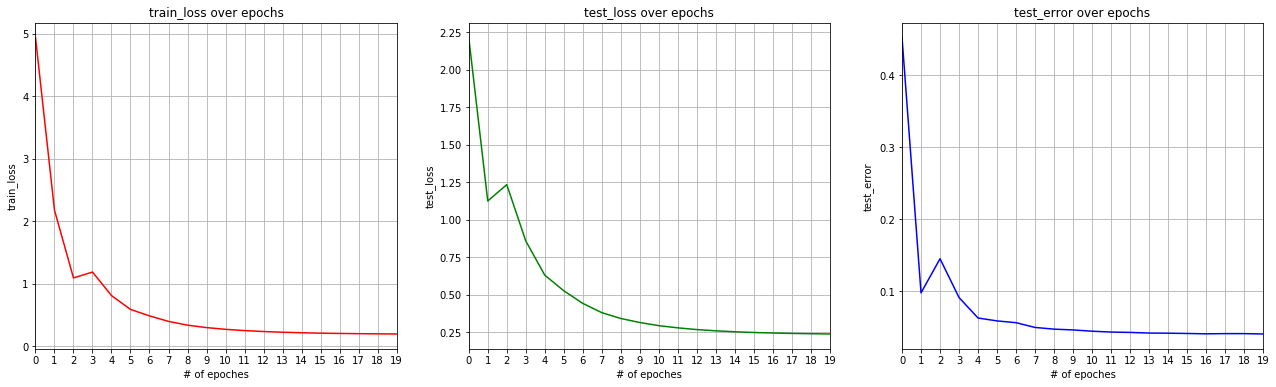

In [8]:
gc.collect() #及时内存回收
num_epochs = 20
lamda = 1 / (train_df_rcv1.shape[0] + test_df_rcv1.shape[0])
train_loss, test_loss, test_error = SAG(train_df_rcv1,test_df_rcv1,num_epochs,lamda,learning_rate=0.25)
print("SAG算法——rcv1数据集结果:")
plot_statistic_curves(num_epochs,train_loss,test_loss,test_error)

#### 结果分析：
可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SAG算法的有效性以及鲁棒性  
测试集误差快速下降并收敛到了**0.04**（参照进度条显示的最有一次迭代test_error_epoch=0.0401），**和原论文中所展示的结果一致！**复现正确！  

**3.3.2 SAG算法——covtype数据集结果**

Epoch Loop: 100%|██████████| 15/15 [02:31<00:00, 10.11s/it, test_error_epoch=0.305, test_loss_epoch=0.61, train_loss_epoch=0.608] 


SAG算法——covtype数据集结果:


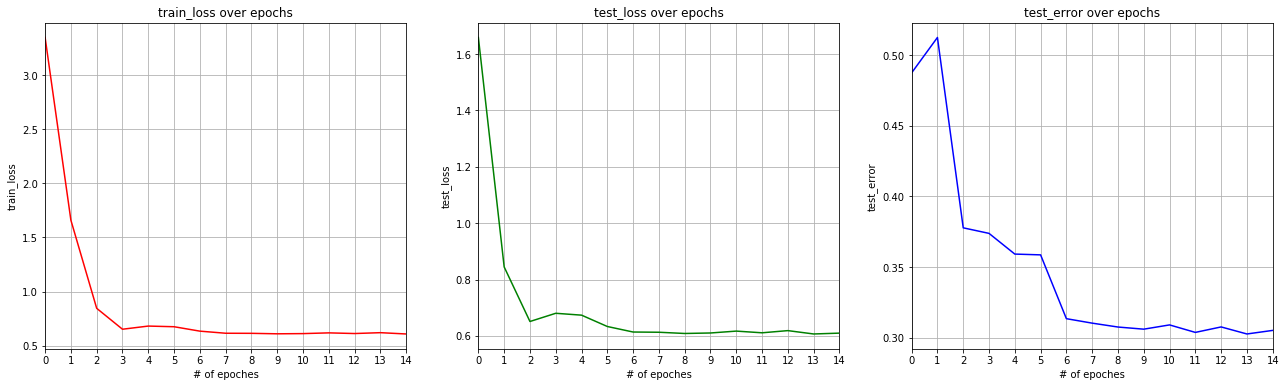

In [9]:
gc.collect() #及时内存回收
num_epochs = 15
lamda = 1 / (train_df_covtype.shape[0] + test_df_covtype.shape[0])
train_loss, test_loss, test_error = SAG(train_df_covtype,test_df_covtype,num_epochs,lamda,learning_rate=0.00005)
print("SAG算法——covtype数据集结果:")
plot_statistic_curves(num_epochs,train_loss,test_loss,test_error)

#### 结果分析：
可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SAG算法的有效性以及鲁棒性  
测试集误差快速下降并收敛到了**0.30**左右，原论文中收敛结果为0.245左右（这是本次作业唯一一个没准确复现出的论文结果），这里分析一下原因：因为SAG的假设在于：<相近的迭代步的情况下随机梯度的相关性很强>，而covtype数据集样本数目非常多（58万），外加我的实现方式是每个epoch完整的遍历一遍，这样就会导致再次抽样到同一个样本时距离上一次抽到这个样本已经经历了几万次更新了，相距“太远了”，已经不太能满足<相近的迭代步的情况下随机梯度的相关性很强>这个假设了。因此可以这样改善，对于样本数目少的自然是随机抽样即可，而对于样本数目大的抽样时可以采取某种随迭代变化的偏好分布，保证某一阶段内偏重于见到某一些样本，这样尽量满足<相近的迭代步的情况下随机梯度的相关性很强>的条件。

**3.3.3 SVRG算法——rcv1数据集结果**

Epoch Loop: 100%|██████████| 20/20 [13:22<00:00, 40.14s/it, test_error_epoch=0.0385, test_loss_epoch=0.186, train_loss_epoch=0.124]


SVRG算法——rcv1数据集结果:


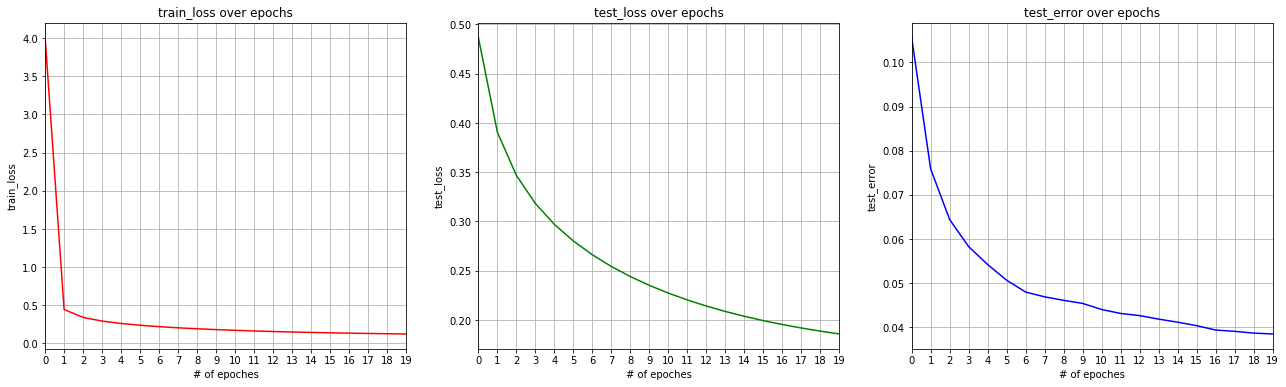

In [10]:
gc.collect() #及时内存回收
num_epochs = 20
lamda = 1e-5
train_loss, test_loss, test_error = SVRG(train_df_rcv1,test_df_rcv1,num_epochs,lamda,learning_rate=0.5)
print("SVRG算法——rcv1数据集结果:")
plot_statistic_curves(num_epochs,train_loss,test_loss,test_error)

#### 结果分析：
可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SVRG算法的有效性以及鲁棒性  
测试集误差快速下降并收敛到了**0.038**左右，**和原论文中所展示的结果一致！**复现正确！

**3.3.4 SVRG算法——Covtype数据集结果**

Epoch Loop: 100%|██████████| 15/15 [03:34<00:00, 14.32s/it, test_error_epoch=0.243, test_loss_epoch=0.514, train_loss_epoch=0.517]


SVRG算法——Covtype数据集结果:


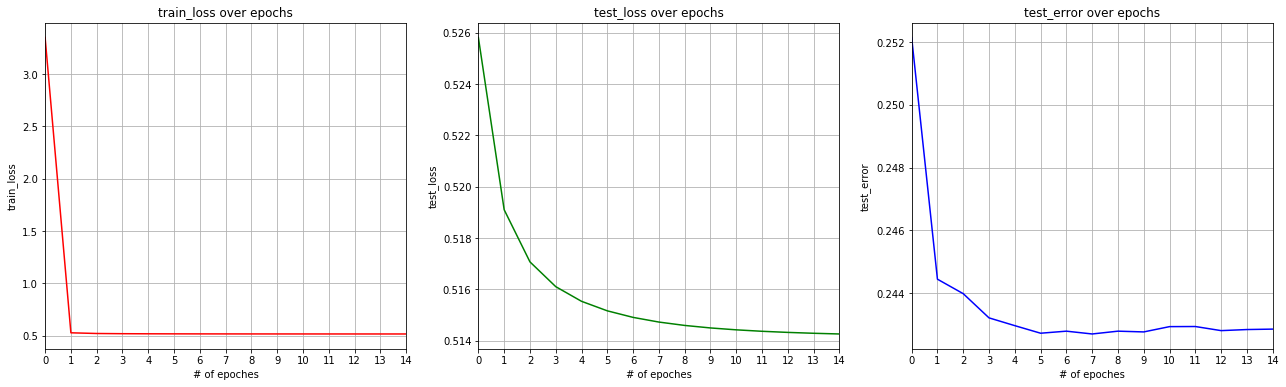

In [11]:
gc.collect() #及时内存回收
num_epochs = 15
lamda = 1e-5
train_loss, test_loss, test_error = SVRG(train_df_covtype,test_df_covtype,num_epochs,lamda,learning_rate=0.005)
print("SVRG算法——Covtype数据集结果:")
plot_statistic_curves(num_epochs,train_loss,test_loss,test_error)

#### 结果分析：
可以看到训练目标函数（loss函数）快速下降并收敛，同时测试集目标函数值也快速下降说明SVRG算法的有效性以及鲁棒性  
测试集误差快速下降并收敛到了**0.243**左右，**和原论文中所展示的结果一致！**复现正确~

### 总结：
本作业阅读了两篇梯度聚合角度对SGD改进的优化算法论文SAG和SVRG，并分别针对rcv1和covtype数据集进行了实验，并正确复现出了两篇原文的实验结果。  
最后说一下个人对于两个算法的对比和看法：  
1、从实验结果来看SVRG准确率是稍微优于SAG的（不管是covtype这样的大样本数据集还是rcv1这种高维度数据集，SVRG同样epoch数下的错误率都更低）  
2、从时间消耗方面来看SVRG同样的epoch数会比SAG时间长（参照上面进度条中显示的时间，SVRG算法在rcv1数据集用时13分钟，而SAG用时9分钟）。